In [1]:
from glob import glob
import pandas as pd
from skbio.diversity.alpha import shannon, simpson_e, observed_otus
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

sns.set_context('talk')
sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})
sns.set_style('whitegrid')

# Alpha diversity analysis
##### Michael Shaffer
##### 7/27/22
##### Merck ESC, Sys bio group

Analyzing baby samples to look at the diversity of genes present across samples.

## Read in data

In [2]:
meta = pd.read_csv('../../data/metadata/stool/stool_metadata.csv', index_col='SampleID')
meta = pd.concat([meta,
                  pd.read_csv('../../data/stool/ko_alpha_diversity.csv', index_col='SampleID'),
                  pd.read_csv('../../data/metadata/stool/stool_abx_usage.csv', index_col='SampleID'),
                  pd.read_csv('../../data/metadata/stool/stool_titers_yr1.csv', index_col='SampleID')],
                 axis=1)
meta = meta.query('`gt_2.5` == True')
meta['VR_group'] = meta['VR_group'].fillna('Not Measured')
meta = meta.sort_values(['BabyN', 'age_at_collection'])
meta.head()

,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,BabyN_checked,...,median_mmNorm_PCV,median_mmNorm_DTAPHib,protectNorm_Dip,protectNorm_TET,protectNorm_PRP (Hib),protectNorm_PT,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2
SampleID,,,,,,,,,,,,,,,,,,,,,
101_V3,Primary in Tube,701.0,NaN,NaN,Box23,Stool,Human Infant,MetaG,101.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101_S1,Primary in Tube,707.0,NaN,NaN,Box23,Stool,Human Infant,MetaG,101.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101_V5,Primary in Tube,704.0,NaN,NaN,Box23,Stool,Human Infant,MetaG,101.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102_V1,Primary in Tube,700.0,NaN,NaN,Box23,Stool,Human Infant,MetaG,102.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102_V3,Primary in Tube,708.0,NaN,NaN,Box23,Stool,Human Infant,MetaG,102.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Investigating Shannon diversity

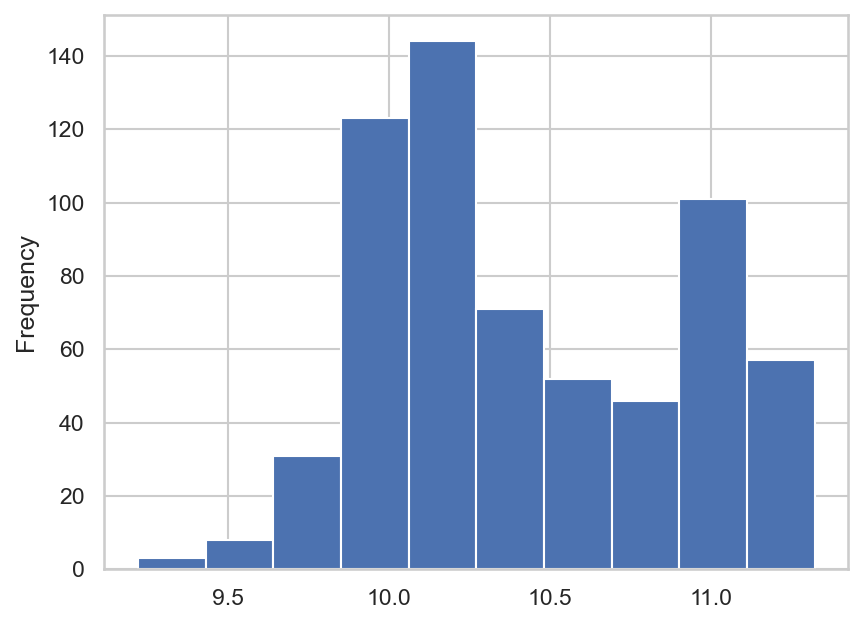

In [3]:
_ = meta['ko_shannon'].plot(kind='hist')

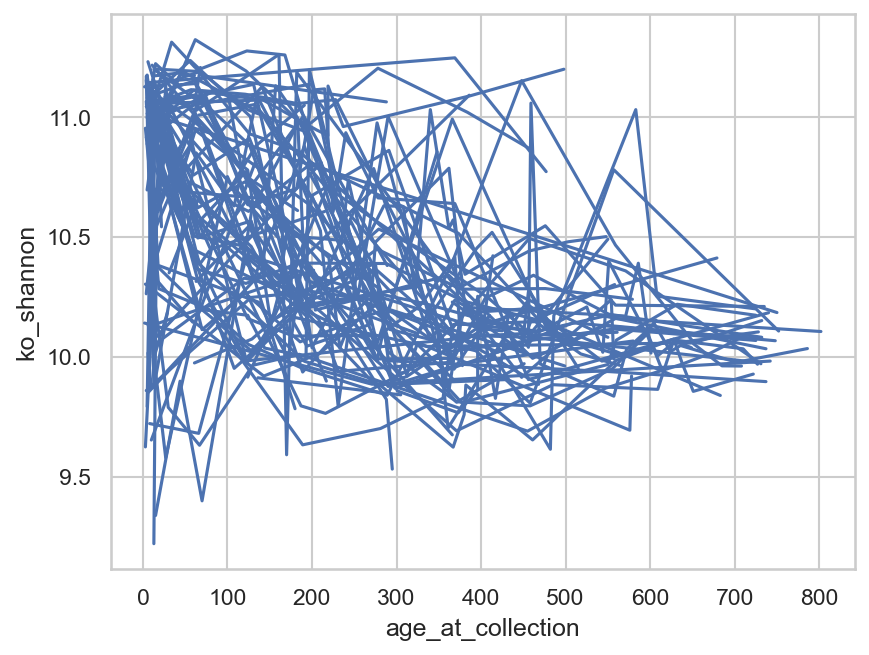

In [4]:
_ = sns.lineplot(x='age_at_collection', y='ko_shannon', units='BabyN', estimator=None, markers=True, data=meta)

A very non-normal distribution. Maybe a decrease in diversity over time on average when we look within babies?

In [5]:
baby_delta_frame = list()
for baby, baby_frame in meta.groupby('BabyN'):
    if baby_frame.shape[0] > 5:
        baby_frame = baby_frame.sort_values('age_at_collection')
        d_alpha_div = list(baby_frame['ko_shannon'].shift(-1) - baby_frame['ko_shannon'])[:-1]
        age_at_second_sample = list(baby_frame['age_at_collection'])[:-1]
        baby_delta_frame.append(pd.DataFrame([d_alpha_div, age_at_second_sample, [baby] * len(d_alpha_div)],
                                             index=['delta_alpha_div', 'age_at_second_sample', 'BabyN']).transpose())

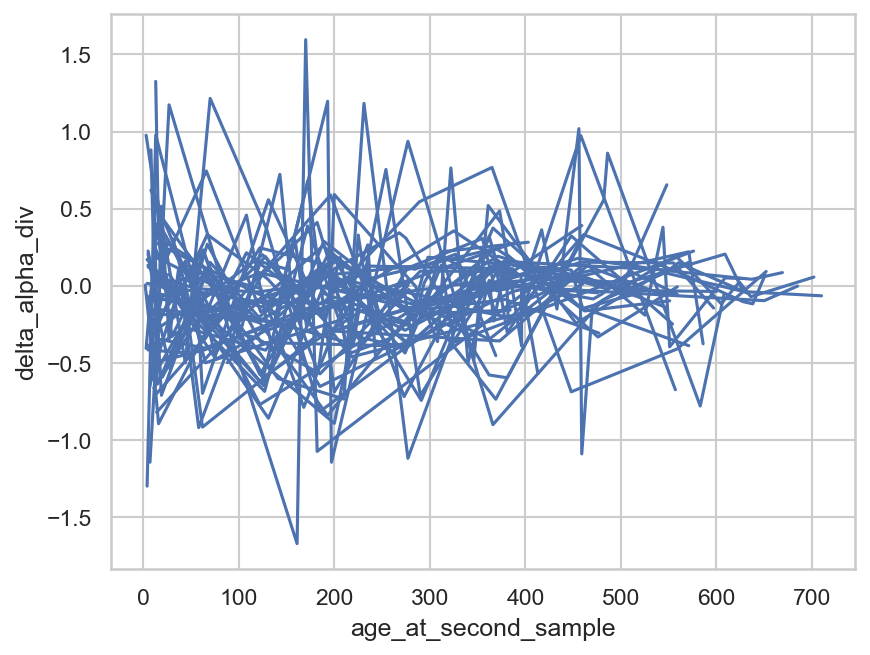

In [6]:
_ = sns.lineplot(x='age_at_second_sample', y='delta_alpha_div', units='BabyN', estimator=None, markers=True, data=pd.concat(baby_delta_frame).reset_index())

Plotting the delta alpha diversities doesn't give a clear pattern.

In [7]:
abx_usage = pd.read_csv('../../data/metadata/antibiotic_usage.tsv', sep='\t')
abx_usage.head()

,PrimaryKey,BabyN,AntibioticN,Name,Class,Reason,Start_Date,End_Date,Duration_(days)
0,Baby134_Antibiotic1,Baby134,1,piperacillin/ tazobactam,penicillin,R/O sepsis,2018-11-26,2018-11-28,2
1,Baby134_Antibiotic2,Baby134,2,ampicillin,penicillin,R/O sepsis,2018-11-26,2018-11-27,1
2,Baby134_Antibiotic3,Baby134,3,gentamicin,aminoglycoside,R/O sepsis,2018-11-26,2018-11-27,1
3,Baby134_Antibiotic4,Baby134,4,vancomycin,glycopeptide,R/O sepsis,2018-11-26,2018-11-27,1
4,Baby235_Antibiotic1,Baby235,1,unknown anitbiotic(s),unknown,"R/O sepsis, later confirmed neg.",2018-06-19,Not Documented,Unknown


In [8]:
babies_w_abx = [int(i.split('Baby')[-1]) for i in set(abx_usage['BabyN'])]

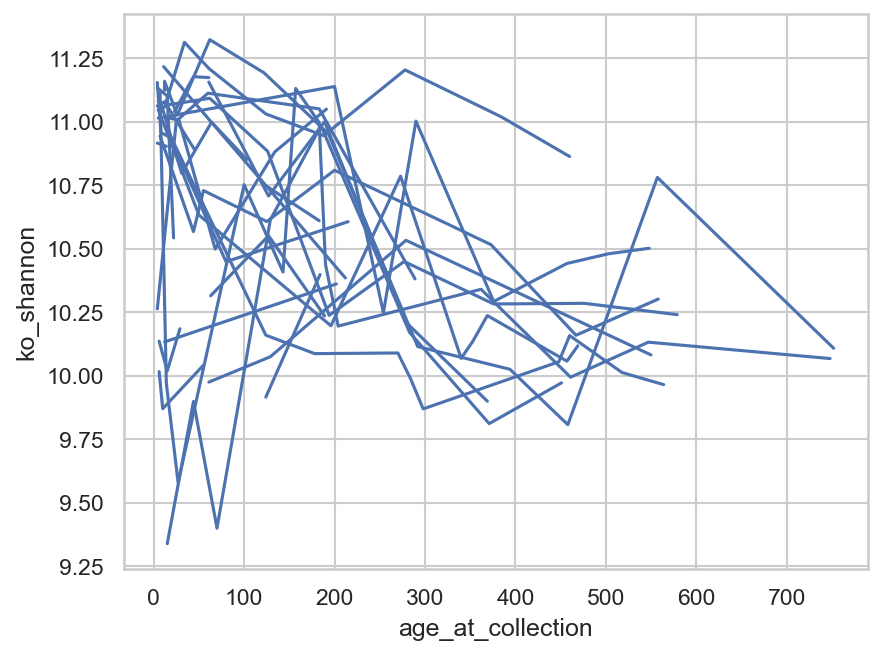

In [9]:
meta_no_abx = meta.loc[[i not in babies_w_abx for i in meta['BabyN']]]
_ = sns.lineplot(x='age_at_collection', y='ko_shannon', units='BabyN', estimator=None, markers=True, data=meta_no_abx)

Getting rid of babies who were no abx does not make for a more clear signal.

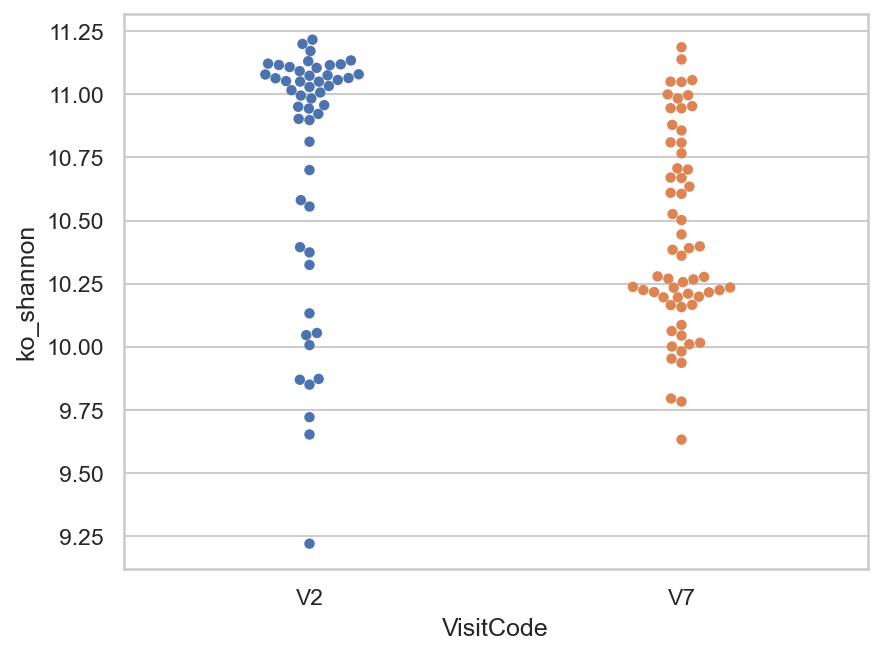

In [10]:
_ = sns.swarmplot(x='VisitCode', y='ko_shannon', data=meta.query("VisitCode in ['V2', 'V7']"))

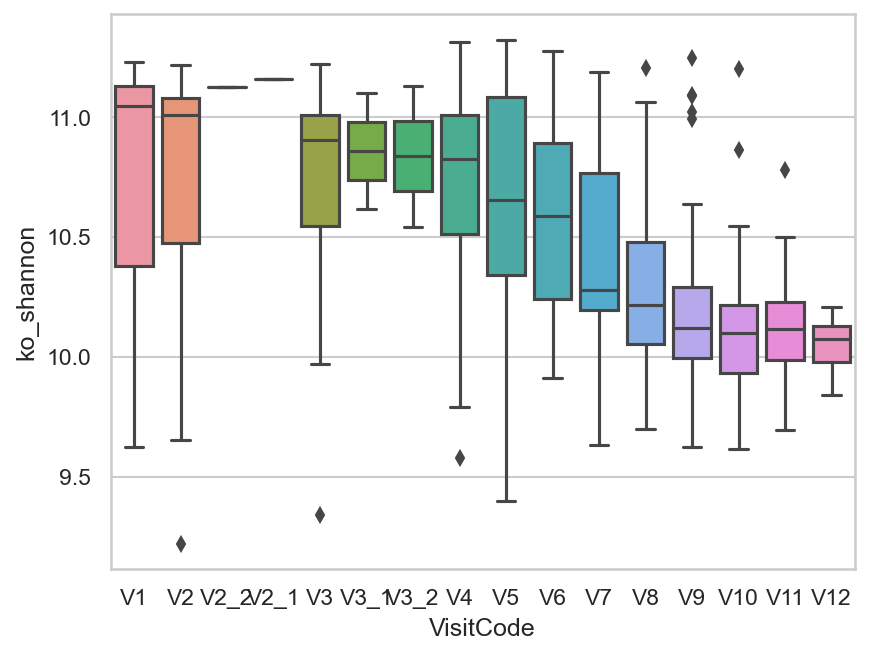

In [11]:
visit_codes = [i for i in meta['VisitCode'] if i.startswith('V')]
_ = sns.boxplot(x='VisitCode', y='ko_shannon', data=meta.query("VisitCode in @visit_codes").sort_values('age_at_collection'))

Comparing 2 weeks to 6 months. Looks like shannon does go down over time.

## Simpson's E

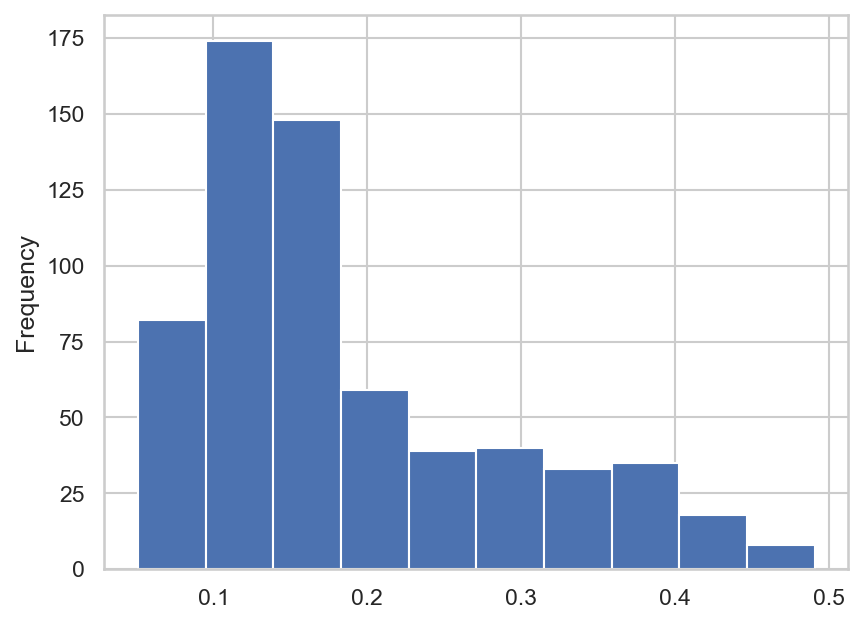

In [12]:
_ = meta['ko_evenness'].plot(kind='hist')

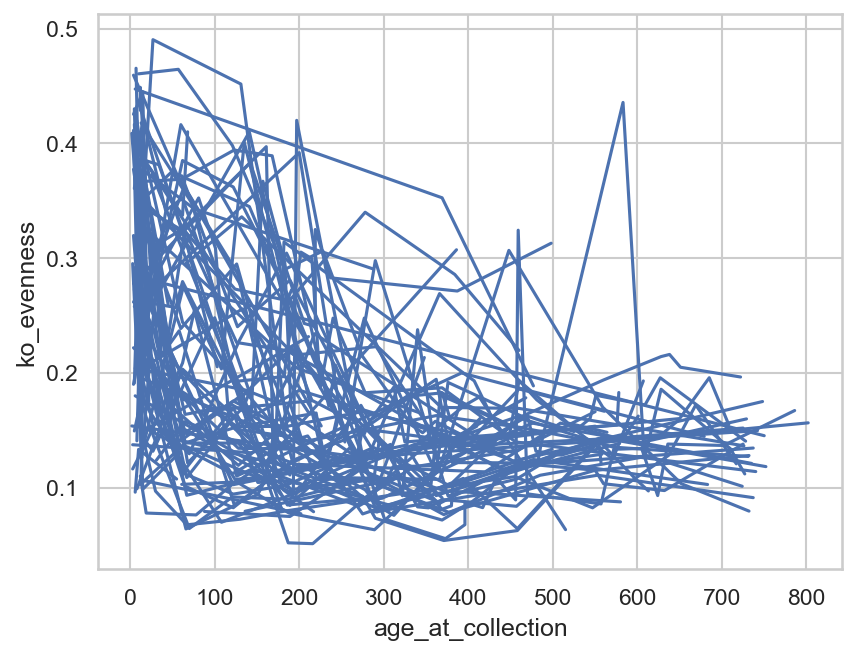

In [13]:
_ = sns.lineplot(x='age_at_collection', y='ko_evenness', units='BabyN', estimator=None, markers=True, data=meta)

Decrease in evenness over time.

## Number of KOs

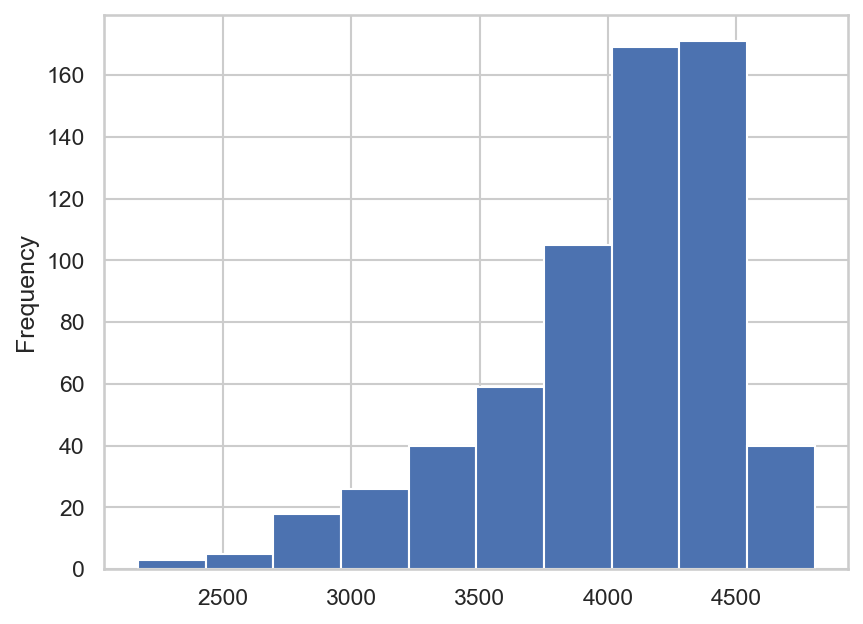

In [14]:
_ = meta['ko_richness'].plot(kind='hist')

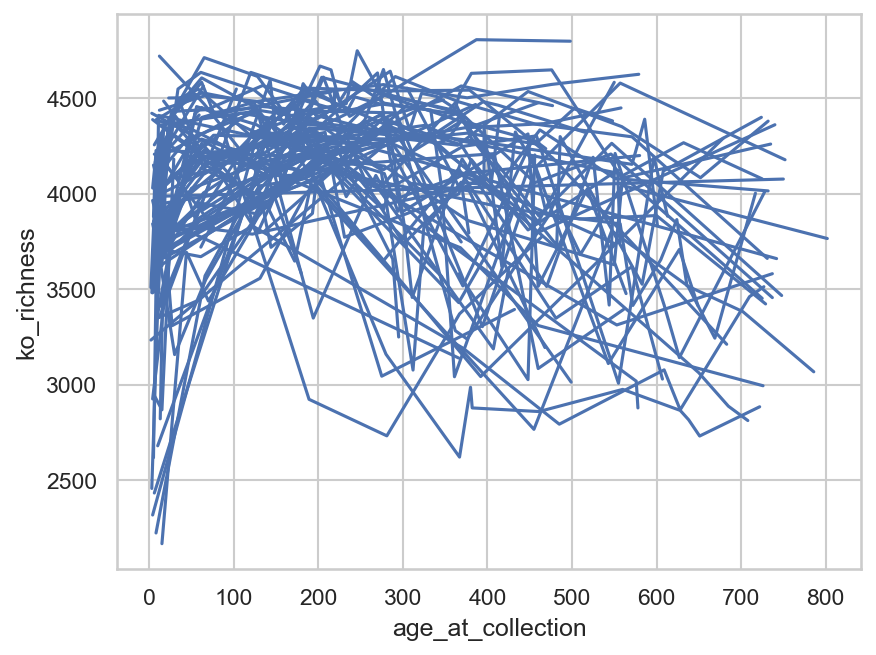

In [15]:
_ = sns.lineplot(x='age_at_collection', y='ko_richness', units='BabyN', estimator=None, markers=True, data=meta)

Seems like a quick increase in number of KOs which then gets very noisy.

## Plot both

Inspired by https://journals.asm.org/doi/10.1128/mSphere.01019-20

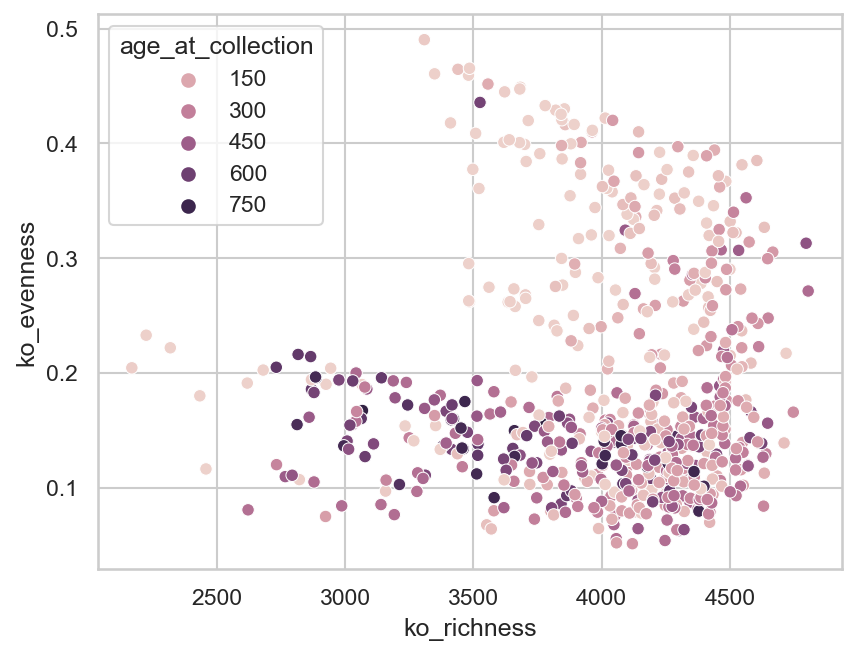

In [16]:
_ = sns.scatterplot(x='ko_richness', y='ko_evenness', hue='age_at_collection', data=meta)

Looks like all the older samples are in the lower part of the plot. So lower evenness but more of a diversity of number of KOs.

## Add vaccine outcome

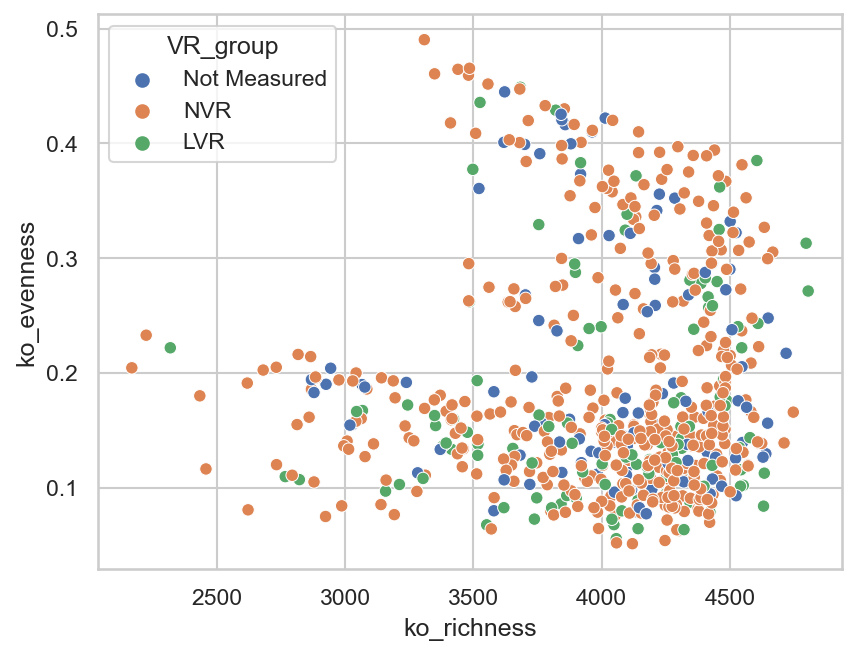

In [17]:
_ = sns.scatterplot(x='ko_richness', y='ko_evenness', hue='VR_group', data=meta)

In [18]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
meta['2mo_sample'] = (meta['VisitCode'] == 'V5').astype(int)
meta['4mo_sample'] = meta['VisitCode'] == 'V6'
meta['6mo_sample'] = meta['VisitCode'] == 'V7'
meta['1yr_sample'] = meta['VisitCode'] == 'V9'
meta = meta.sort_values('VR_group')

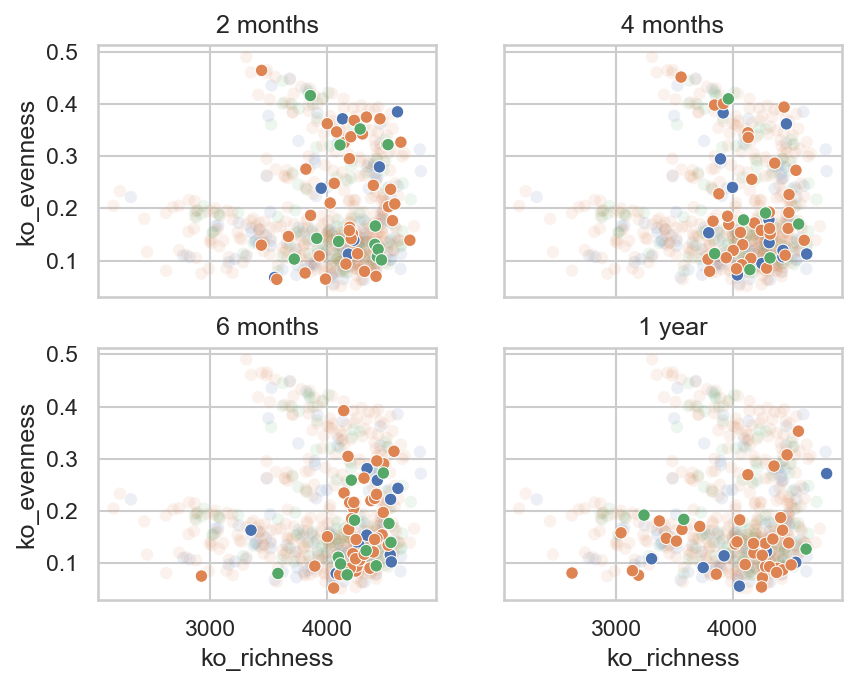

In [19]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

ax1 = sns.scatterplot(x="ko_richness", y="ko_evenness", hue='VR_group',
                     data=meta.loc[meta['2mo_sample'] == 0], alpha=0.1, legend=False, ax=axs[0,0])
ax1 = sns.scatterplot(x="ko_richness", y="ko_evenness", hue='VR_group',
                     data=meta[meta['2mo_sample'] == 1], alpha=1.0, legend=False, ax=axs[0,0])
_ = ax1.set_title('2 months')

ax2 = sns.scatterplot(x="ko_richness", y="ko_evenness", hue='VR_group',
                     data=meta.loc[meta['4mo_sample'] == 0], legend=False, alpha=0.1, ax=axs[0,1])
ax2 = sns.scatterplot(x="ko_richness", y="ko_evenness", hue='VR_group',
                     data=meta[meta['4mo_sample'] == 1], legend=False, alpha=1.0, ax=axs[0,1])
_ = ax2.set_title('4 months')

ax3 = sns.scatterplot(x="ko_richness", y="ko_evenness", hue='VR_group',
                     data=meta.loc[meta['6mo_sample'] == 0], alpha=0.1, legend=False, ax=axs[1,0])
ax3 = sns.scatterplot(x="ko_richness", y="ko_evenness", hue='VR_group',
                     data=meta[meta['6mo_sample'] == 1], alpha=1.0, legend=False, ax=axs[1,0])
_ = ax3.set_title('6 months')

ax4 = sns.scatterplot(x="ko_richness", y="ko_evenness", hue='VR_group',
                     data=meta.loc[meta['1yr_sample'] == 0], alpha=0.1, legend=False, ax=axs[1,1])
ax4 = sns.scatterplot(x="ko_richness", y="ko_evenness", hue='VR_group',
                     data=meta[meta['1yr_sample'] == 1], alpha=1.0, legend=False, ax=axs[1,1])
_ = ax4.set_title('1 year')

No clear pattern associating alpha diversity with VR group.

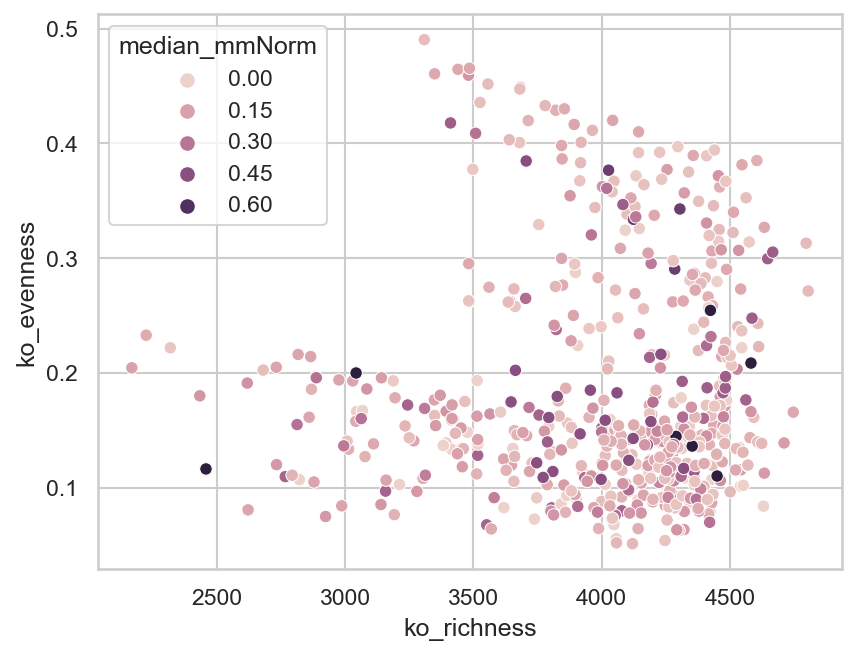

In [20]:
_ = sns.scatterplot(x='ko_richness', y='ko_evenness', hue='median_mmNorm', data=meta)

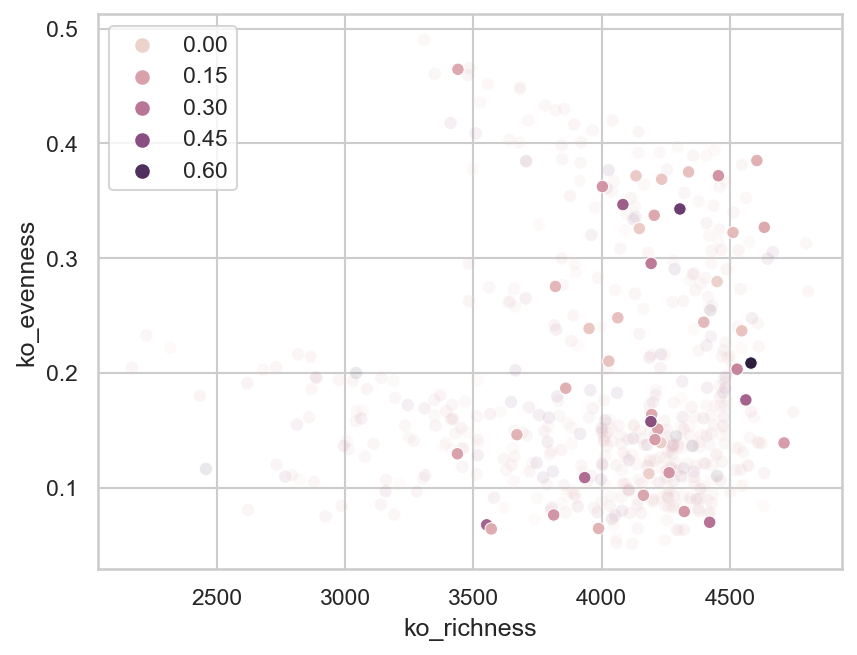

In [21]:
ax = sns.scatterplot(x="ko_richness", y="ko_evenness", hue='median_mmNorm',
                     data=meta.loc[meta['2mo_sample'] == 0], alpha=0.1, hue_norm=(0, meta['median_mmNorm'].max()))
ax = sns.scatterplot(x="ko_richness", y="ko_evenness", hue='median_mmNorm',
                     data=meta[meta['2mo_sample'] == 1], alpha=1.0, ax=ax, hue_norm=(0, meta['median_mmNorm'].max()))
legend_without_duplicate_labels(ax)

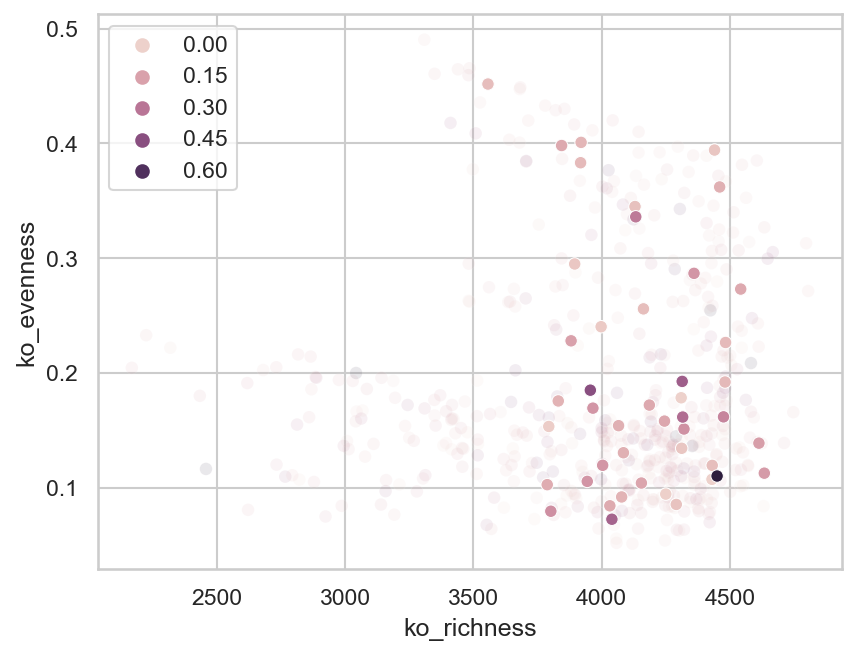

In [22]:
ax = sns.scatterplot(x="ko_richness", y="ko_evenness", hue='median_mmNorm',
                     data=meta.loc[meta['4mo_sample'] == 0], alpha=0.1, hue_norm=(0, meta['median_mmNorm'].max()))
ax = sns.scatterplot(x="ko_richness", y="ko_evenness", hue='median_mmNorm',
                     data=meta[meta['4mo_sample'] == 1], alpha=1.0, ax=ax, hue_norm=(0, meta['median_mmNorm'].max()))
legend_without_duplicate_labels(ax)

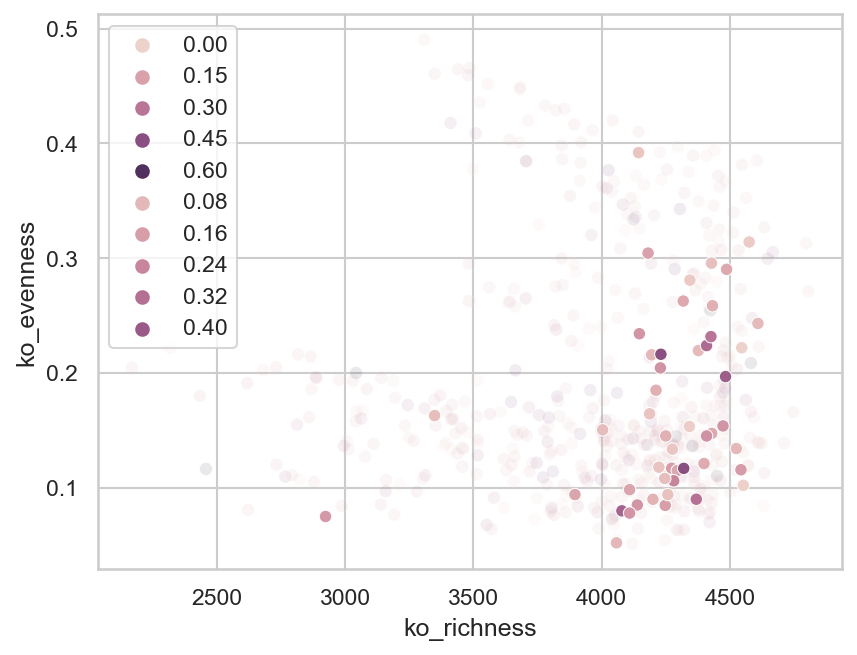

In [23]:
ax = sns.scatterplot(x="ko_richness", y="ko_evenness", hue='median_mmNorm',
                     data=meta.loc[meta['6mo_sample'] == 0], alpha=0.1, hue_norm=(0, meta['median_mmNorm'].max()))
ax = sns.scatterplot(x="ko_richness", y="ko_evenness", hue='median_mmNorm',
                     data=meta[meta['6mo_sample'] == 1], alpha=1.0, ax=ax, hue_norm=(0, meta['median_mmNorm'].max()))
legend_without_duplicate_labels(ax)

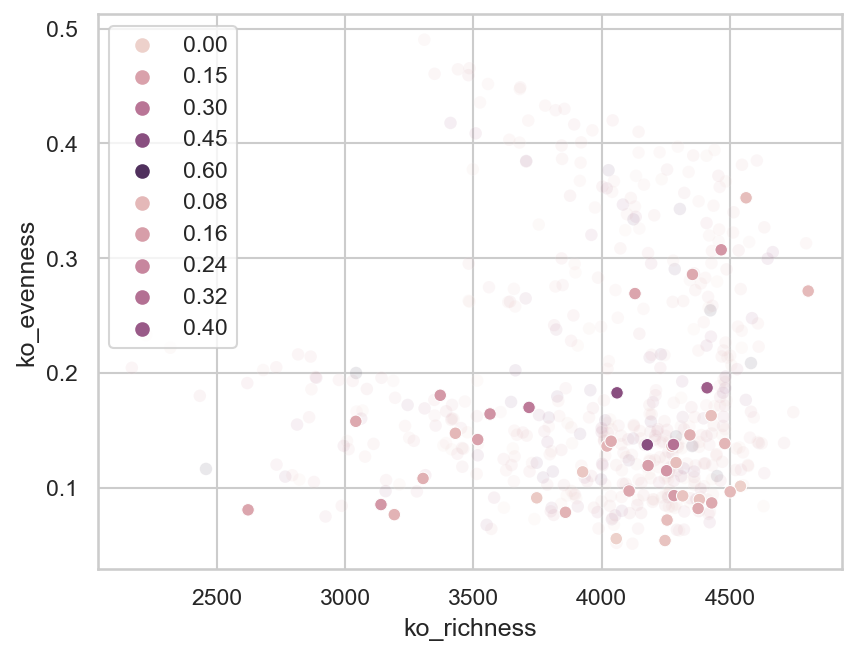

In [24]:
ax = sns.scatterplot(x="ko_richness", y="ko_evenness", hue='median_mmNorm',
                     data=meta.loc[meta['1yr_sample'] == 0], alpha=0.1, hue_norm=(0, meta['median_mmNorm'].max()))
ax = sns.scatterplot(x="ko_richness", y="ko_evenness", hue='median_mmNorm',
                     data=meta[meta['1yr_sample'] == 1], alpha=1.0, ax=ax, hue_norm=(0, meta['median_mmNorm'].max()))
legend_without_duplicate_labels(ax)

No clear pattern associating alpha diversity with continuous titer.

## Add abx

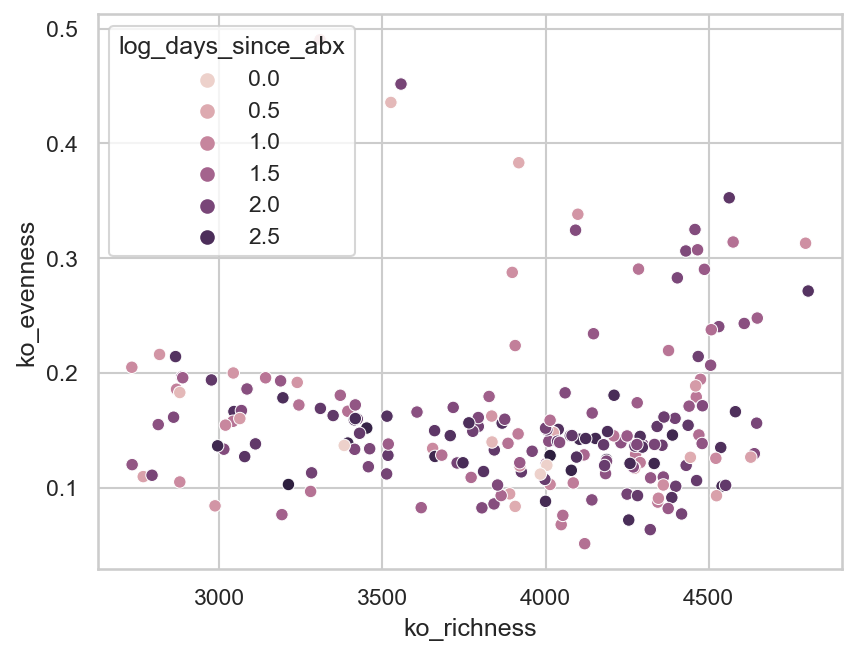

In [25]:
meta['log_days_since_abx'] = np.log10(meta['days_since_abx_end'])
_ = sns.scatterplot(x='ko_richness', y='ko_evenness', hue='log_days_since_abx', data=meta)

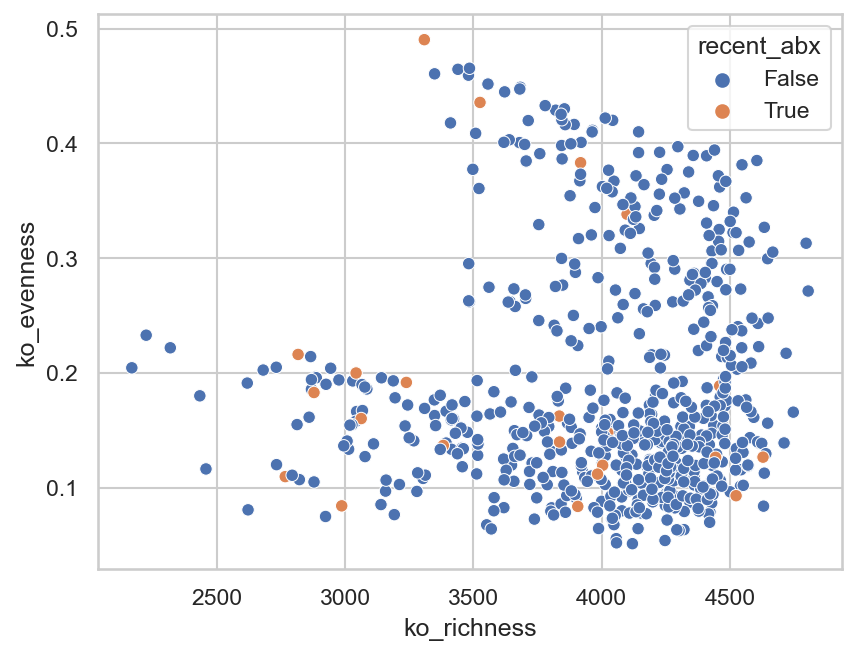

In [26]:
meta['recent_abx'] = meta['days_since_abx_end'] < 7
_ = sns.scatterplot(x='ko_richness', y='ko_evenness', hue='recent_abx', data=meta)

No pattern with antibiotics.